Found cached dataset fashion_mnist (C:/Users/USER/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)
Loading cached shuffled indices for dataset at C:\Users\USER\.cache\huggingface\datasets\fashion_mnist\fashion_mnist\1.0.0\8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1\cache-d04502ca6afeaa32.arrow


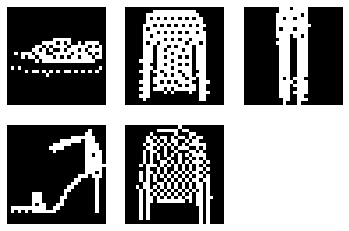

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt

dataset = load_dataset("fashion_mnist", split = "test").shuffle(seed = 999)
patterns = dataset[:5]["image"]

limit_number_of_patterns = 5
n_row = int(limit_number_of_patterns ** 0.5)
n_col = -(limit_number_of_patterns // -n_row)
pattern_plt = plt.figure()
for i, pattern in enumerate(patterns):
    if i >= limit_number_of_patterns:
        break
    
    plt.subplot(n_row, n_col, i + 1)
    plt.axis("off")
    plt.imshow(pattern.convert("1")) # classical hopfield networks can only store bilevel images
    
plt.show()

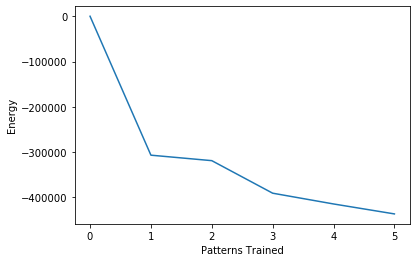

In [2]:
# Training network and energy visualisation
import hf_network

hopfield_network = hf_network.ClassicalHopfield(input_shape = patterns[0].size)
assert len(patterns) <= hopfield_network.storage_capacity_limit() # best to keep number of patterns below storage capacity
energy_list = [0]
for pattern in patterns:
    states = hopfield_network.process_image(pattern)
    hopfield_network.train(states)
    energy_list.append(hopfield_network.energy_function(states))

plt.plot([i for i in range(len(energy_list))], energy_list)
plt.xlabel("Patterns Trained")
plt.ylabel("Energy")
plt.show()

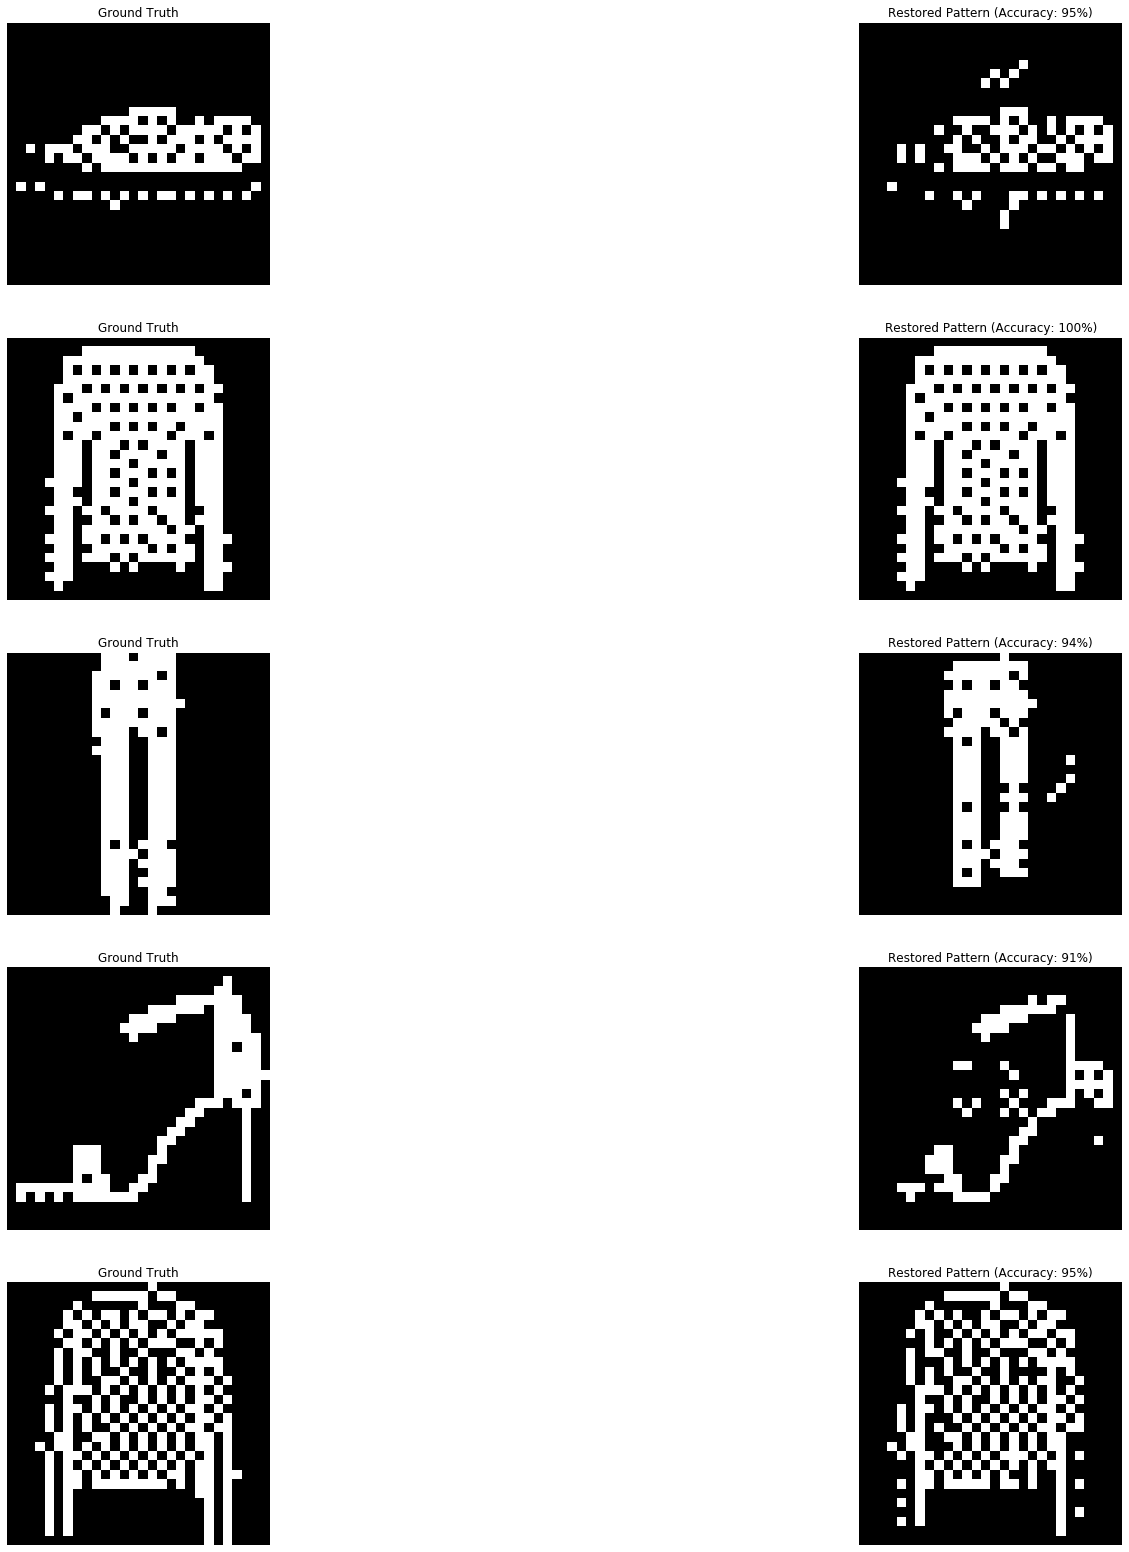

In [3]:
# Testing using ground truth (synchronous)
import numpy as np

limit_number_of_patterns = 5
plt.figure(figsize = (patterns[0].size))
for i, pattern in enumerate(patterns):
    if i >= limit_number_of_patterns:
        break
    
    pattern = pattern.convert("1")
    states = hopfield_network.process_image(pattern)
    predicted_states = hopfield_network.test(states, synchronous = True)
    predicted_pattern = hopfield_network.restore_image(predicted_states)

    plt.subplot(limit_number_of_patterns, 2, i * 2 + 1)
    plt.title("Ground Truth")
    plt.axis("off")
    plt.imshow(pattern)
    plt.subplot(limit_number_of_patterns, 2, (i + 1) * 2)
    plt.title(f"Restored Pattern (Accuracy: {np.sum(np.asarray(pattern) == np.asarray(predicted_pattern)) * 100 // np.prod(pattern.size)}%)")
    plt.axis("off")
    plt.imshow(predicted_pattern)
    
plt.show()

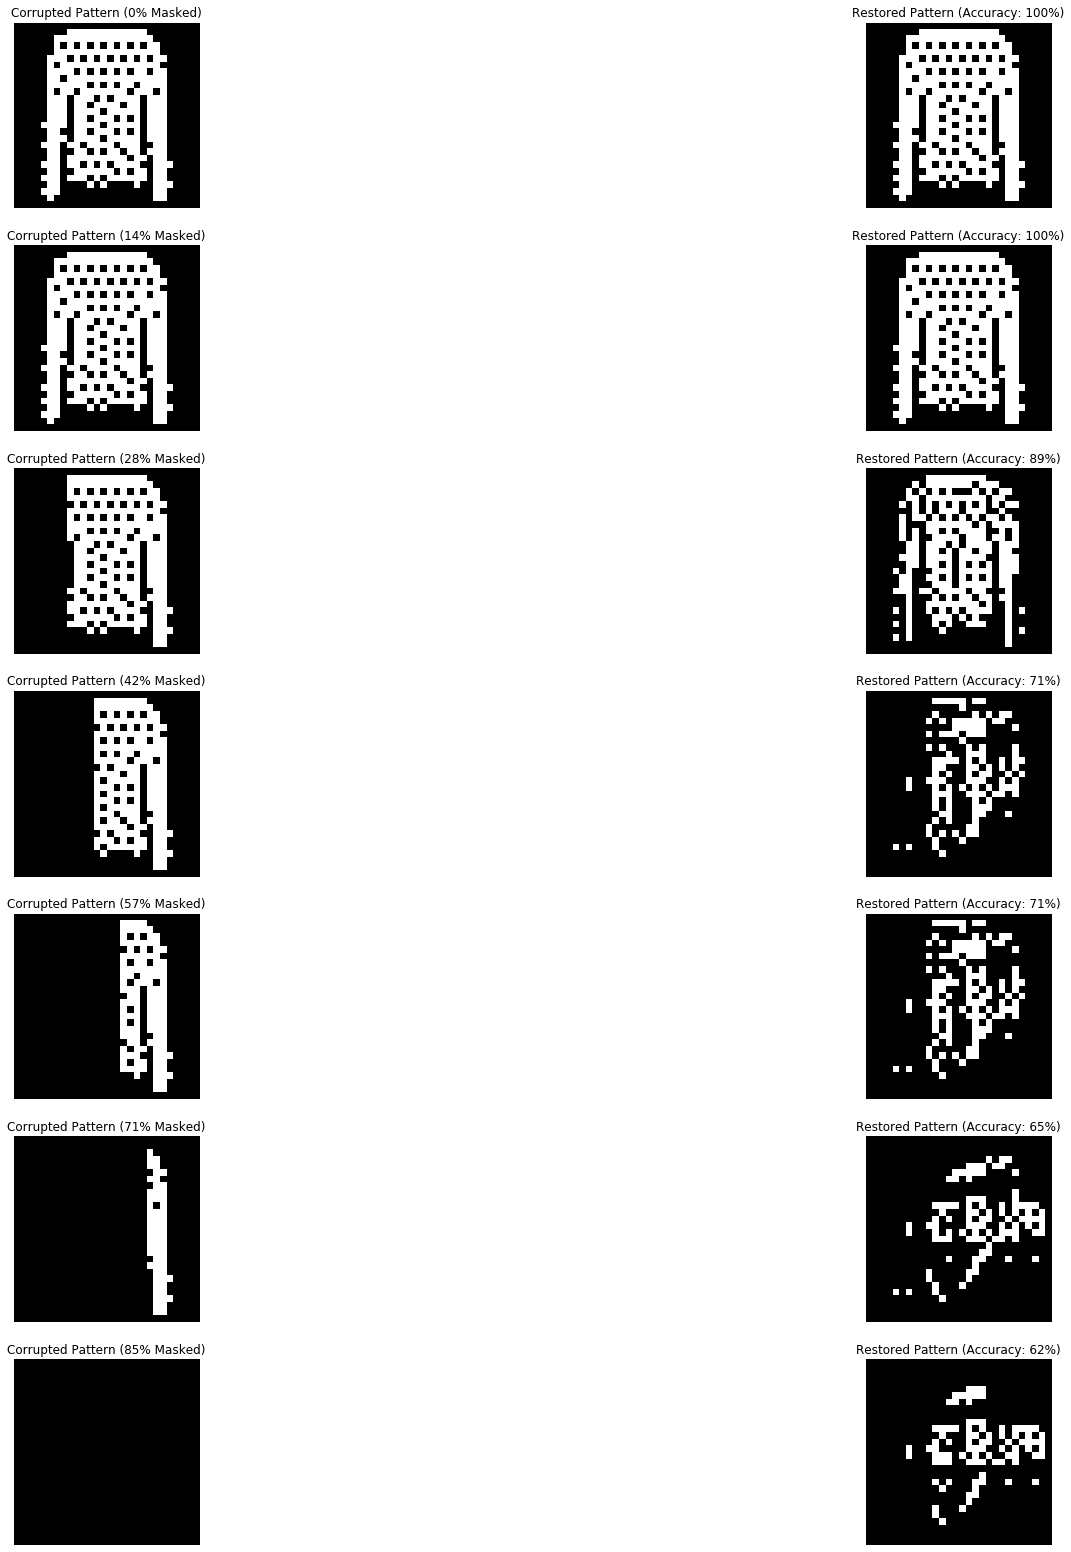

In [4]:
# Testing using corrupted pattern (synchronous)
from PIL import Image

pattern = patterns[1].convert("1") # change index to the pattern you want to test
max_masked_unit = 7
limit_number_of_patterns = 7
plt.figure(figsize = (pattern.size[0], pattern.size[1]))
for masked_unit in range(max_masked_unit):
    if masked_unit >= limit_number_of_patterns:
        break
    
    mask_width = pattern.size[0] * masked_unit // max_masked_unit
    mask = Image.new("1", (mask_width, pattern.size[1]))
    corrupted_pattern = pattern.copy()
    corrupted_pattern.paste(mask)
    corrupted_states = hopfield_network.process_image(corrupted_pattern)
    predicted_states = hopfield_network.test(corrupted_states, synchronous = True)
    predicted_pattern = hopfield_network.restore_image(predicted_states)
    
    plt.subplot(limit_number_of_patterns, 2, masked_unit * 2 + 1)
    plt.title(f"Corrupted Pattern ({mask_width * 100 // pattern.size[0]}% Masked)")
    plt.axis("off")
    plt.imshow(corrupted_pattern)
    plt.subplot(limit_number_of_patterns, 2, (masked_unit + 1) * 2)
    plt.title(f"Restored Pattern (Accuracy: {np.sum(np.asarray(pattern) == np.asarray(predicted_pattern)) * 100 // np.prod(pattern.size)}%)")
    plt.axis("off")
    plt.imshow(predicted_pattern)

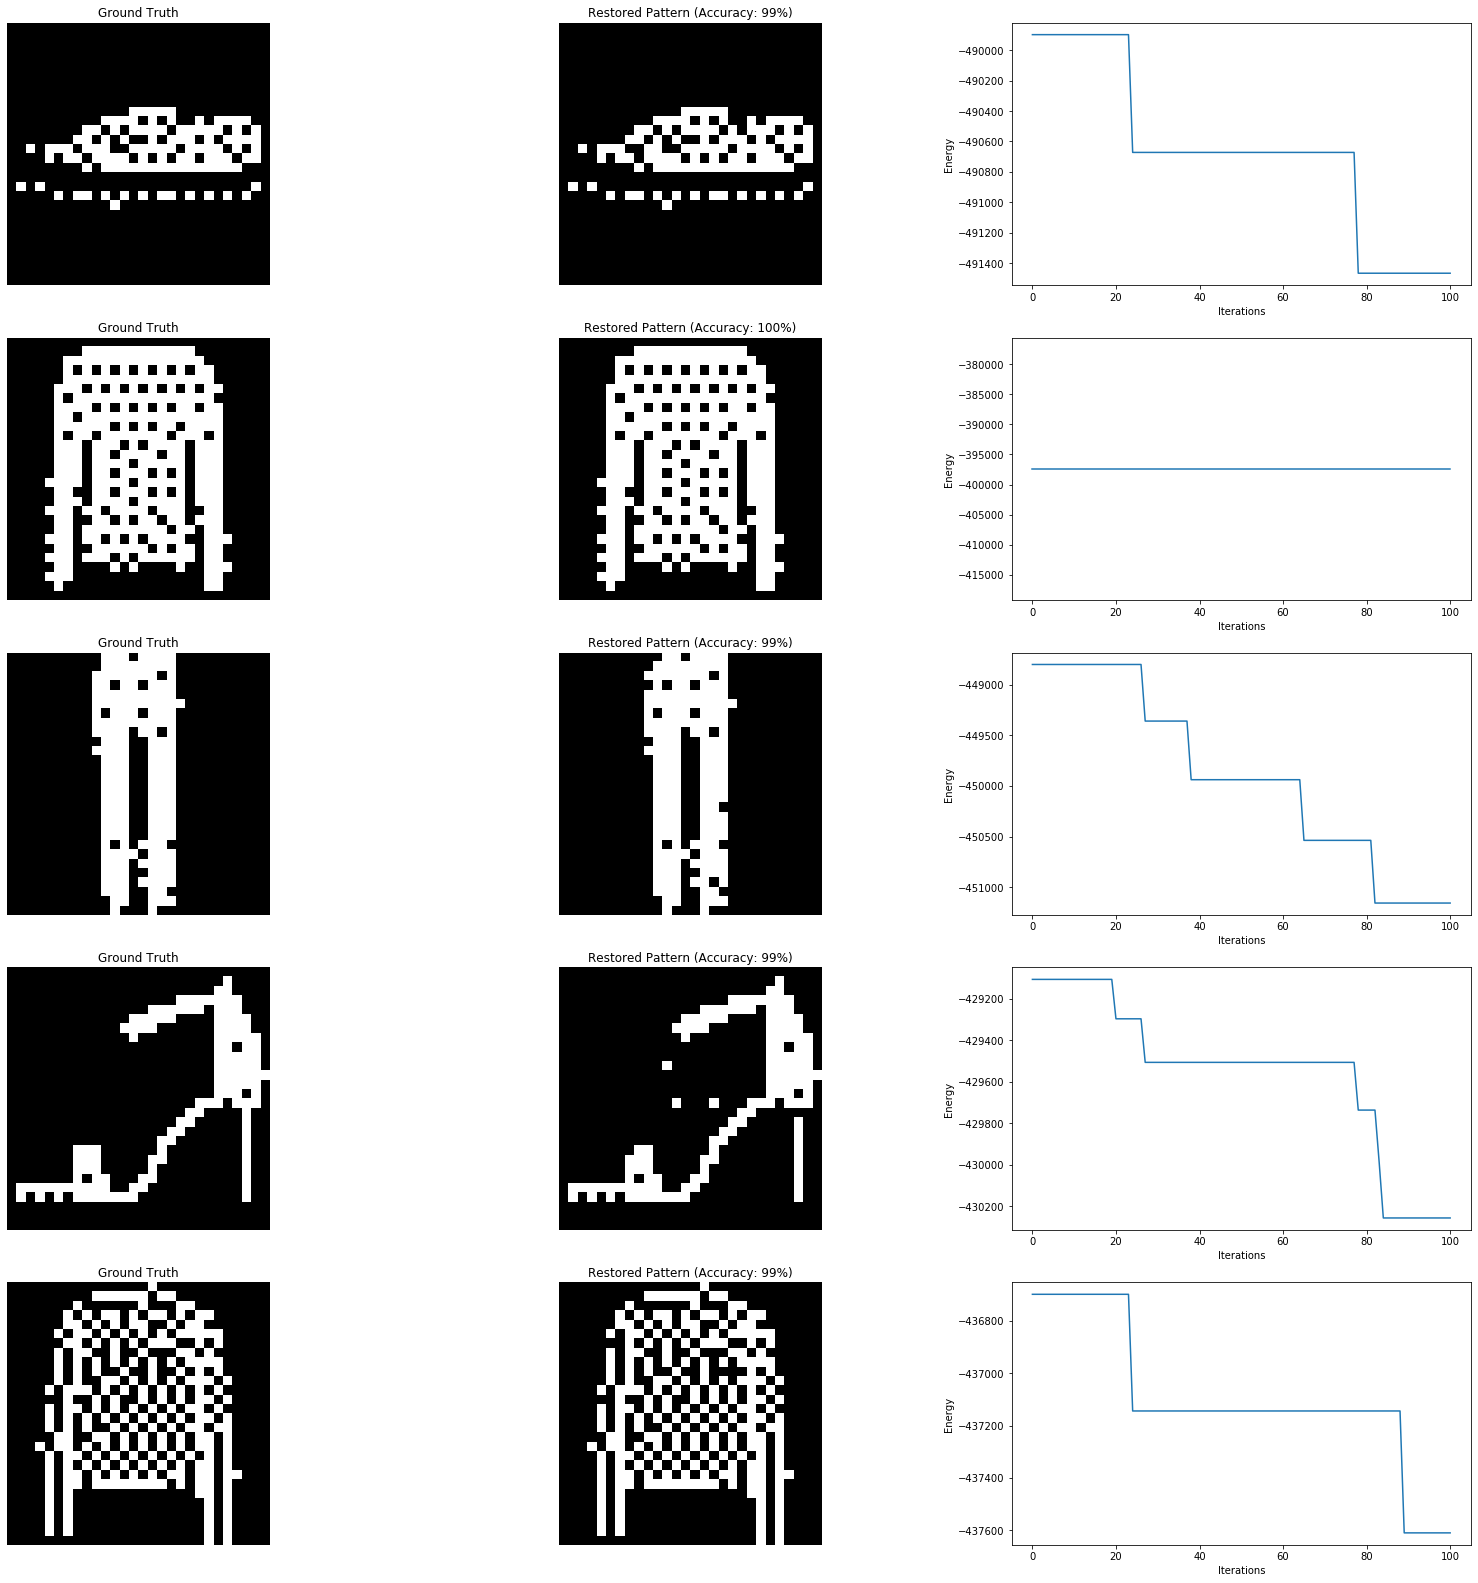

In [5]:
# Testing using ground truth (asynchronous)
np.random.seed(999) # for reproducibility, just like the seed for shuffling our dataset

limit_number_of_patterns = 5
plt.figure(figsize = (patterns[0].size))
for i, pattern in enumerate(patterns):
    if i >= limit_number_of_patterns:
        break
    
    pattern = pattern.convert("1")
    states = hopfield_network.process_image(pattern)
    predicted_states = states.copy()
    energy_list = [hopfield_network.energy_function(predicted_states)]
    for _ in range(100): # asynchronous update for 100 iterations; iterating test() instead of setting it as a parameter so that we can plot energy graph
        predicted_states = hopfield_network.test(predicted_states, synchronous = False)
        energy_list.append(hopfield_network.energy_function(predicted_states))
    predicted_pattern = hopfield_network.restore_image(predicted_states)

    plt.subplot(limit_number_of_patterns, 3, i * 3 + 1)
    plt.title("Ground Truth")
    plt.axis("off")
    plt.imshow(pattern)
    plt.subplot(limit_number_of_patterns, 3, i * 3 + 2)
    plt.title(f"Restored Pattern (Accuracy: {np.sum(np.asarray(pattern) == np.asarray(predicted_pattern)) * 100 // np.prod(pattern.size)}%)")
    plt.axis("off")
    plt.imshow(predicted_pattern)
    plt.subplot(limit_number_of_patterns, 3, (i + 1) * 3)
    plt.xlabel("Iterations")
    plt.ylabel("Energy")
    plt.plot([i for i in range(len(energy_list))], energy_list)
    
plt.show()

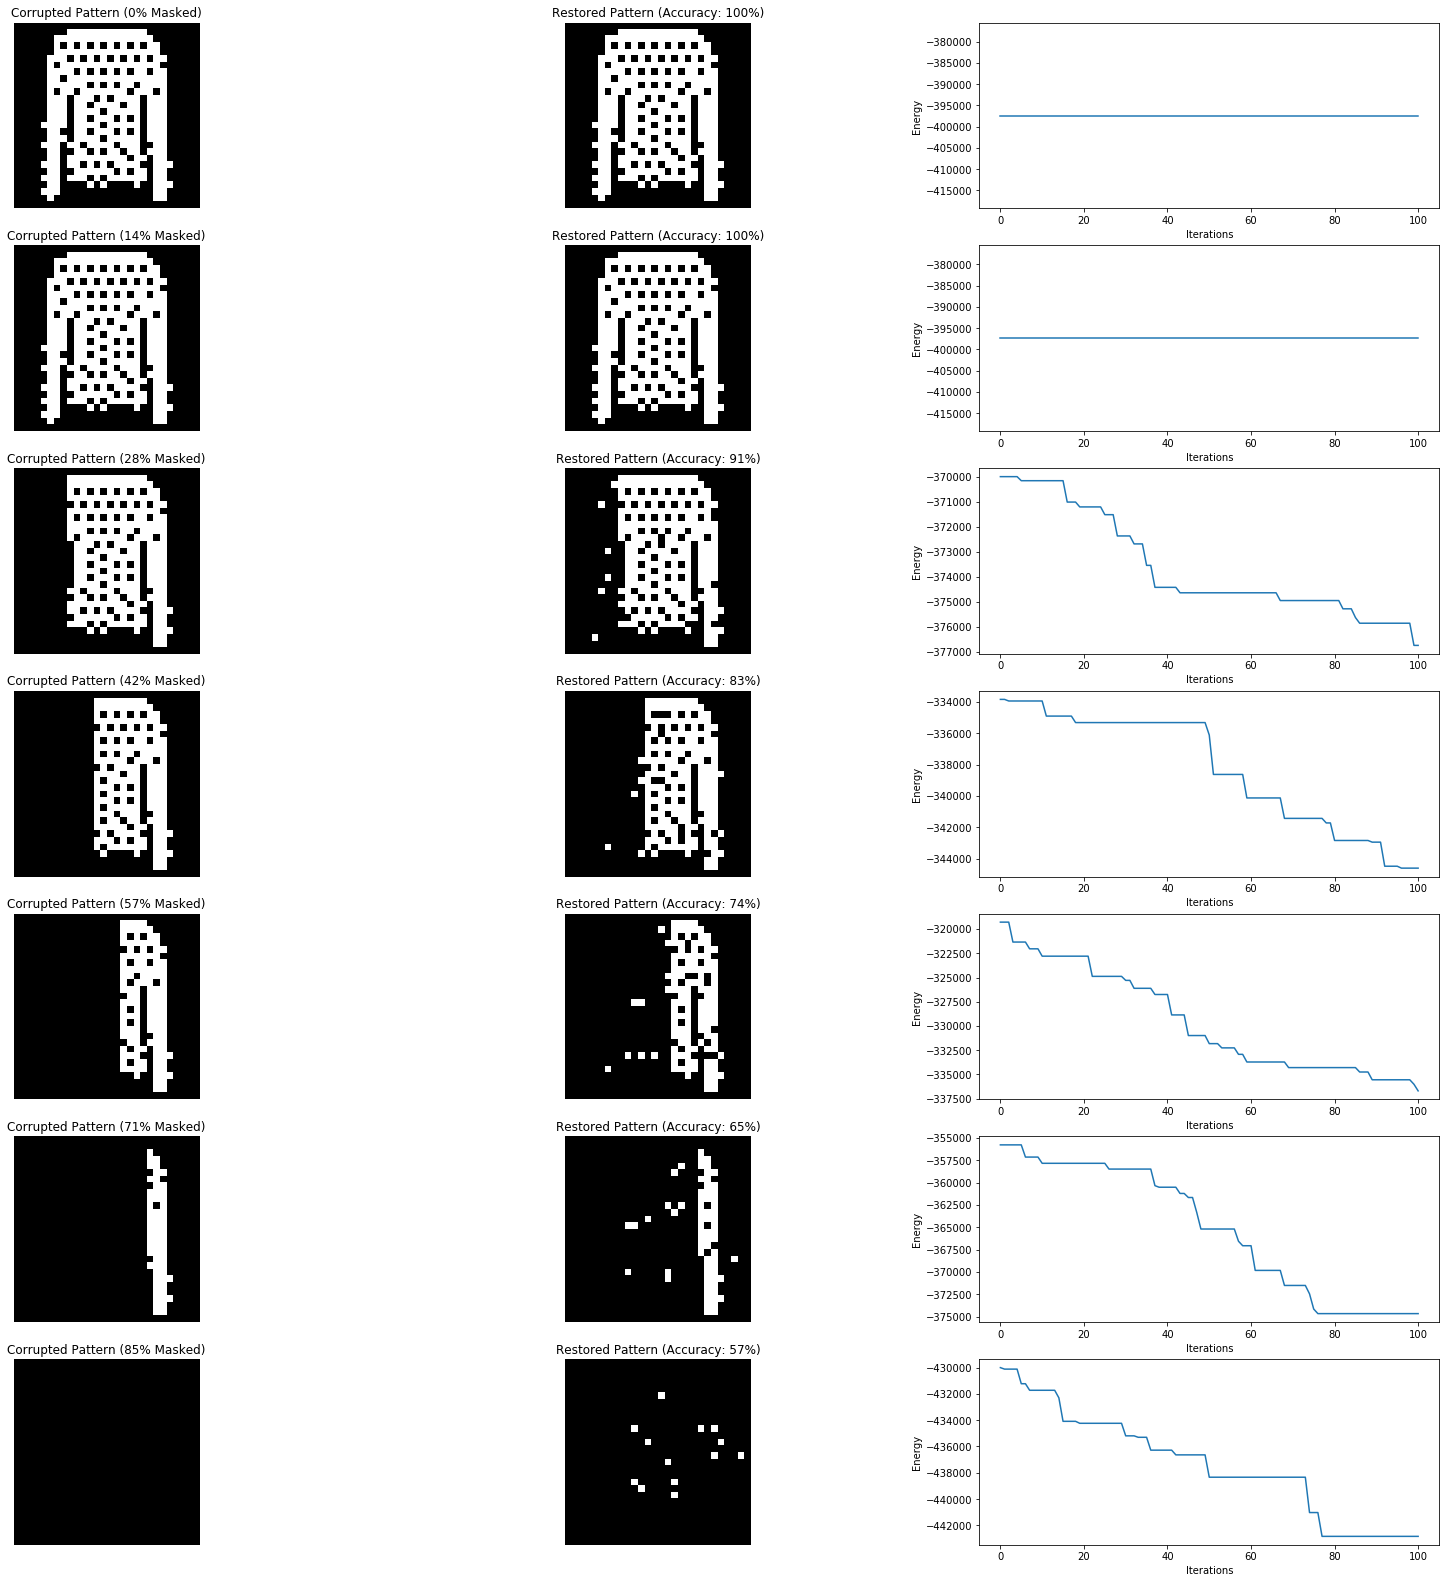

In [6]:
# Testing using corrupted pattern (asynchronous)
pattern = patterns[1].convert("1") # change index to the pattern you want to test
max_masked_unit = 7
limit_number_of_patterns = 7
plt.figure(figsize = (pattern.size[0], pattern.size[1]))
for masked_unit in range(max_masked_unit):
    if masked_unit >= limit_number_of_patterns:
        break
    
    mask_width = pattern.size[0] * masked_unit // max_masked_unit
    mask = Image.new("1", (mask_width, pattern.size[1]))
    corrupted_pattern = pattern.copy()
    corrupted_pattern.paste(mask)
    corrupted_states = hopfield_network.process_image(corrupted_pattern)
    predicted_states = corrupted_states.copy()
    energy_list = [hopfield_network.energy_function(predicted_states)]
    for _ in range(100): # asynchronous update for 100 iterations; iterating test() instead of setting it as a parameter so that we can plot energy graph
        predicted_states = hopfield_network.test(predicted_states, synchronous = False)
        energy_list.append(hopfield_network.energy_function(predicted_states))
    predicted_pattern = hopfield_network.restore_image(predicted_states)
    
    plt.subplot(limit_number_of_patterns, 3, masked_unit * 3 + 1)
    plt.title(f"Corrupted Pattern ({mask_width * 100 // pattern.size[0]}% Masked)")
    plt.axis("off")
    plt.imshow(corrupted_pattern)
    plt.subplot(limit_number_of_patterns, 3, masked_unit * 3 + 2)
    plt.title(f"Restored Pattern (Accuracy: {np.sum(np.asarray(pattern) == np.asarray(predicted_pattern)) * 100 // np.prod(pattern.size)}%)")
    plt.axis("off")
    plt.imshow(predicted_pattern)
    plt.subplot(limit_number_of_patterns, 3, (masked_unit + 1) * 3)
    plt.xlabel("Iterations")
    plt.ylabel("Energy")
    plt.plot([i for i in range(len(energy_list))], energy_list)
    
plt.show()